In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
df_final = pd.read_csv('modelling_dataset_final.csv')
y=df_final.two_factor_regimes

In [3]:
df_final = df_final.iloc[:,2:-5]

df_t_minus_2 = df_final.shift(2)
df_t_minus_2.columns = [str(col) + '_t-2' for col in df_t_minus_2.columns]

X = df_t_minus_2
X = X.iloc[2:]
y = y.iloc[2:]
X.head()

,free_cash_flow_t-2,competitive_environment_t-2,strong_demand_bool_t-2,product_cycle_t-2,epidemic_t-2,higher_prices_bool_t-2,government_dissatisfaction_t-2,weak_strategy_bool_t-2,corporate_governance_t-2,management_t-2,...,equipment_failure_t-2,industry_neg_headwinds_t-2,management_defensiveness_t-2,industry_pos_general_t-2,finance_neg_revenue_down_t-2,industry_neg_demand_unstable_t-2,economy_neg_yield_curve_inverting_t-2,management_buzz_growth_t-2,industry_specific_ltip_drivers_t-2,industry_neg_margin_larger_t-2
2,24.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,...,0.0,0.0,12.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,16.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,24.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0


In [4]:
len(X)

806

In [5]:
len(y)

806

In [6]:
pca = PCA(n_components=20)
pca.fit(X)
X_reduced = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y,test_size=.3,random_state=168)

In [7]:
# define a function to show model performance
def show_result(y_test,predicted):
    '''show all results from the model, takes y_test and predicted Y value'''
    print(metrics.classification_report(y_test,predicted))
    print("Accuracy: {0:.2f}".format(metrics.accuracy_score(y_test, predicted)))
    print("confusion matrix: \n\n",metrics.confusion_matrix(y_test, predicted))

# define a function to plot ROC with auc
def plot_ROC(y_test,predicted_prob):
    '''plot ROC curve with auc, takes y_test and predicted probability for Y=1'''
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)
    roc_auc = metrics.auc(fpr, tpr)
    # Plot the ROC curve
    plt.plot(fpr,tpr,'b',label = 'AUC = %.2f' %roc_auc)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc = 'lower right')
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0, 1]);plt.ylim([0, 1])
    plt.show()

In [8]:
# Hyper parameter tuning
param_grid = {'min_samples_leaf': [2,3],'max_depth': [10,11,12,13], 'n_estimators':[100,200,250]}
model = RandomForestClassifier(random_state=168)
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}

              precision    recall  f1-score   support

         0.0       0.74      0.96      0.83       165
         1.0       0.77      0.26      0.39        77

   micro avg       0.74      0.74      0.74       242
   macro avg       0.75      0.61      0.61       242
weighted avg       0.75      0.74      0.69       242

Accuracy: 0.74
confusion matrix: 

 [[159   6]
 [ 57  20]]


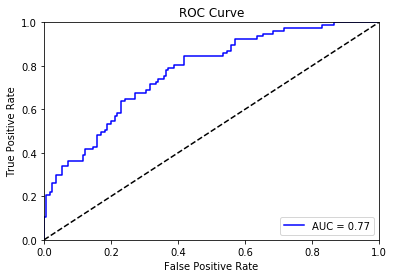

In [9]:
# n=20
model = RandomForestClassifier(random_state=168,max_depth= 10, n_estimators= 200,min_samples_leaf=2)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
model.fit(X_train, y_train) 
pred = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

# Select probability where Y = 1
pred_prob = predicted_prob[:,1]

# Use pre-defined function to see model performance 
show_result(y_test,pred)
plot_ROC(y_test,pred_prob)